In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from scipy.interpolate import interp1d, interp2d

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sea

from astropy.cosmology import Planck13 as cosmo
from astropy import units as u
from astropy.io import fits
from astropy.table import Table

from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_exam import Gen_spec

import fsps
from grizli import multifit
from grizli import model
from grizli.utils import SpectrumTemplate


import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

# plot Ha

In [89]:
fls = glob('../data/linefits/*Ha*')

field = [os.path.basename(U).split('_')[0] for U in fls]
gid = [os.path.basename(U).split('_')[1] for U in fls]

zfl = []
for i in range(len(field)):
    zfl.append(glob('../data/posteriors/{}_{}*Mfit_Pz.npy'.format(field[i], gid[i]))[0])

In [19]:
GN1l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GN1_lines_grizli.fits'), format = 'fits').to_pandas()
GN2l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GN2_lines_grizli.fits'), format = 'fits').to_pandas()
GN3l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GN3_lines_grizli.fits'), format = 'fits').to_pandas()
GN4l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GN4_lines_grizli.fits'), format = 'fits').to_pandas()
GN5l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GN5_lines_grizli.fits'), format = 'fits').to_pandas()
GN7l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GN7_lines_grizli.fits'), format = 'fits').to_pandas()

GS1l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GS1_lines_grizli.fits'), format = 'fits').to_pandas()
GS2l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GS2_lines_grizli.fits'), format = 'fits').to_pandas()
GS3l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GS3_lines_grizli.fits'), format = 'fits').to_pandas()
GS4l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GS4_lines_grizli.fits'), format = 'fits').to_pandas()
GS5l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GS5_lines_grizli.fits'), format = 'fits').to_pandas()
ERSPRIMEl = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/ERSPRIME_lines_grizli.fits'), format = 'fits').to_pandas()

In [83]:
# z_50	z_02	z_16	z_84z_50	z_02	z_16	z_84

In [91]:
GND_lines = [GN1l, GN2l,GN3l,GN4l, GN5l, GN7l]
GSD_lines = [GS1l, GS2l,GS3l,GS4l, GS5l, ERSPRIMEl]

Ha_g_fluxes = []
Ha_g_err = []
z50_g = []
zer_g = []

for i in range(len(field)):
    if field[i][1] == 'N':
        for F in GND_lines:
            FLUX = F.query('ID == {}'.format(gid[i])).Ha_FLUX.values * 1E-17
            ERR = F.query('ID == {}'.format(gid[i])).Ha_FLUX_ERR.values * 1E-17
            RS = F.query('ID == {}'.format(gid[i])).z_50.values
            RSERRH = F.query('ID == {}'.format(gid[i])).z_84.values
            RSERRL = F.query('ID == {}'.format(gid[i])).z_16.values

            if len(FLUX) > 0:
                Ha_g_fluxes.append(FLUX[0])
                Ha_g_err.append(ERR[0])
                
                z50_g.append(RS[0])
                zer_g.append((RSERRH[0] - RSERRL[0]) / 2)
                
                break
                

    if field[i][1] == 'S':
        for F in GSD_lines:
            FLUX = F.query('ID == {}'.format(gid[i])).Ha_FLUX.values * 1E-17
            ERR = F.query('ID == {}'.format(gid[i])).Ha_FLUX_ERR.values * 1E-17
            RS = F.query('ID == {}'.format(gid[i])).z_50.values
            RSERRH = F.query('ID == {}'.format(gid[i])).z_84.values
            RSERRL = F.query('ID == {}'.format(gid[i])).z_16.values
            if len(FLUX) > 0:
                Ha_g_fluxes.append(FLUX[0])
                Ha_g_err.append(ERR[0])
                
                z50_g.append(RS[0])
                zer_g.append((RSERRH[0] - RSERRL[0]) / 2)
                break
                
Ha_v_fluxes = []
Ha_v_err = []               
for f in fls:
    x,px = np.load(f)
    m, hci, mod = Highest_density_region(px,x)
    Ha_v_fluxes.append(m)
    Ha_v_err.append((hci[1] - hci[0]) / 2)    

z_v= []
zerr_v = []               
for f in zfl:
    x,px = np.load(f)
    m, hci, mod = Highest_density_region(px,x)
    z_v.append(m)
    zerr_v.append((hci[1] - hci[0]) / 2)  

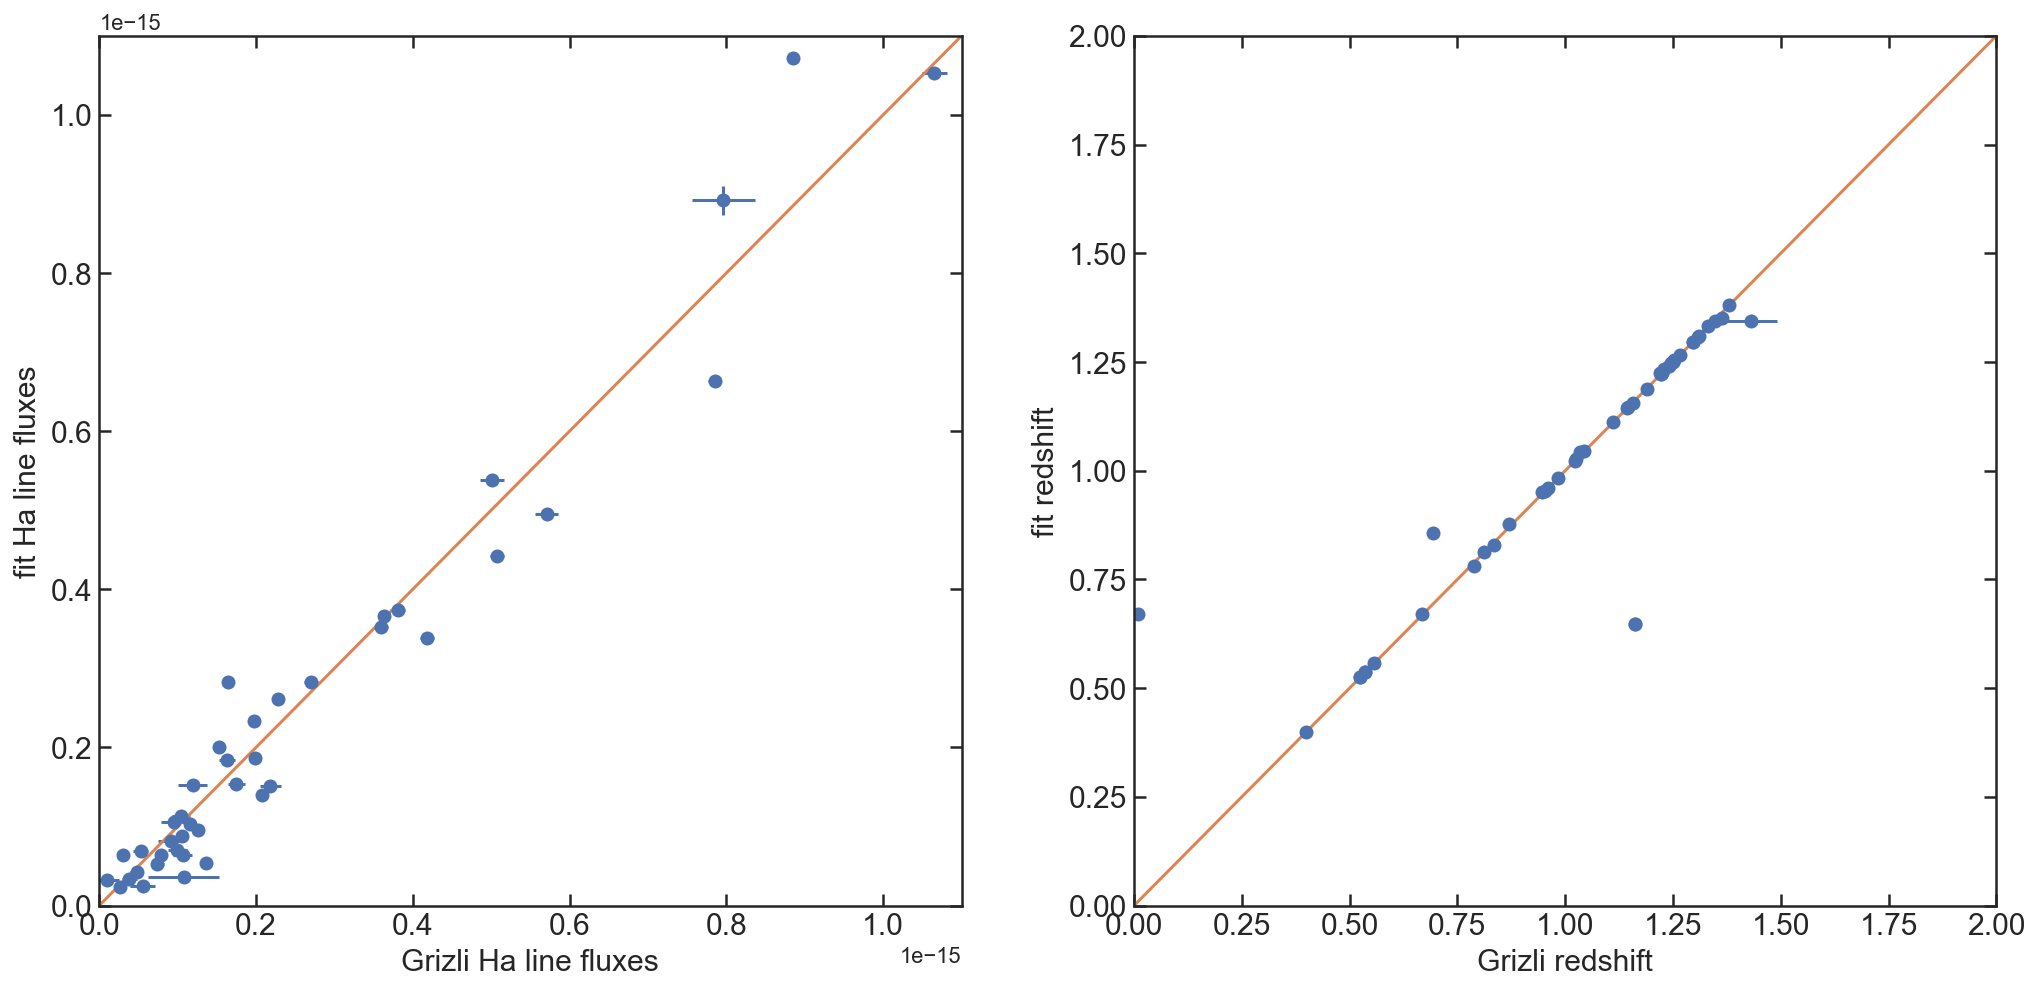

In [96]:
gs = gridspec.GridSpec(1,2)

plt.figure(figsize=[17,8])
plt.subplot(gs[0])
plt.errorbar(Ha_g_fluxes, Ha_v_fluxes,xerr = Ha_g_err, yerr=Ha_v_err ,linestyle = 'none', marker = 'o')
plt.plot([0,1.1E-15],[0,1.1E-15])
plt.xlim(0,1.1E-15)
plt.ylim(0,1.1E-15)

plt.ylabel('fit Ha line fluxes', fontsize=15)
plt.xlabel('Grizli Ha line fluxes', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(gs[1])
plt.errorbar(z50_g, z_v, xerr = zer_g, yerr=zerr_v ,linestyle = 'none', marker = 'o')
plt.plot([0,4],[0,4])
plt.xlim(0,2)
plt.ylim(0,2)

plt.ylabel('fit redshift', fontsize=15)
plt.xlabel('Grizli redshift', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('../plots/Ha_compare.png', bbox_inches = 'tight')

# Plot Hb

In [97]:
fls = glob('../data/linefits/*Hb*')

field = [os.path.basename(U).split('_')[0] for U in fls]
gid = [os.path.basename(U).split('_')[1] for U in fls]

zfl = []
for i in range(len(field)):
    zfl.append(glob('../data/posteriors/{}_{}*Mfit_Pz.npy'.format(field[i], gid[i]))[0])

In [101]:
Hb_g_fluxes = []
Hb_g_err = []
z50_g = []
zer_g = []

for i in range(len(field)):
    if field[i][1] == 'N':
        for F in GND_lines:
            FLUX = F.query('ID == {}'.format(gid[i])).Hb_FLUX.values * 1E-17
            ERR = F.query('ID == {}'.format(gid[i])).Hb_FLUX_ERR.values * 1E-17
            RS = F.query('ID == {}'.format(gid[i])).z_50.values

            RSERRH = F.query('ID == {}'.format(gid[i])).z_84.values
            RSERRL = F.query('ID == {}'.format(gid[i])).z_16.values
            if len(FLUX) > 0:
                Hb_g_fluxes.append(FLUX[0])
                Hb_g_err.append(ERR[0])
                z50_g.append(RS[0])
                zer_g.append((RSERRH[0] - RSERRL[0]) / 2)
                break                

    if field[i][1] == 'S':
        for F in GSD_lines:
            FLUX = F.query('ID == {}'.format(gid[i])).Hb_FLUX.values * 1E-17
            ERR = F.query('ID == {}'.format(gid[i])).Hb_FLUX_ERR.values * 1E-17
            RS = F.query('ID == {}'.format(gid[i])).z_50.values

            RSERRH = F.query('ID == {}'.format(gid[i])).z_84.values
            RSERRL = F.query('ID == {}'.format(gid[i])).z_16.values
            if len(FLUX) > 0:
                Hb_g_fluxes.append(FLUX[0])
                Hb_g_err.append(ERR[0])
                z50_g.append(RS[0])
                zer_g.append((RSERRH[0] - RSERRL[0]) / 2)
                break                
Hb_v_fluxes = []
Hb_v_err = []               
for f in fls:
    x,px = np.load(f)
    m, hci, mod = Highest_density_region(px,x)
    Hb_v_fluxes.append(m)
    Hb_v_err.append((hci[1] - hci[0]) / 2)  
    
z_v= []
zerr_v = []               
for f in zfl:
    x,px = np.load(f)
    m, hci, mod = Highest_density_region(px,x)
    z_v.append(m)
    zerr_v.append((hci[1] - hci[0]) / 2)  

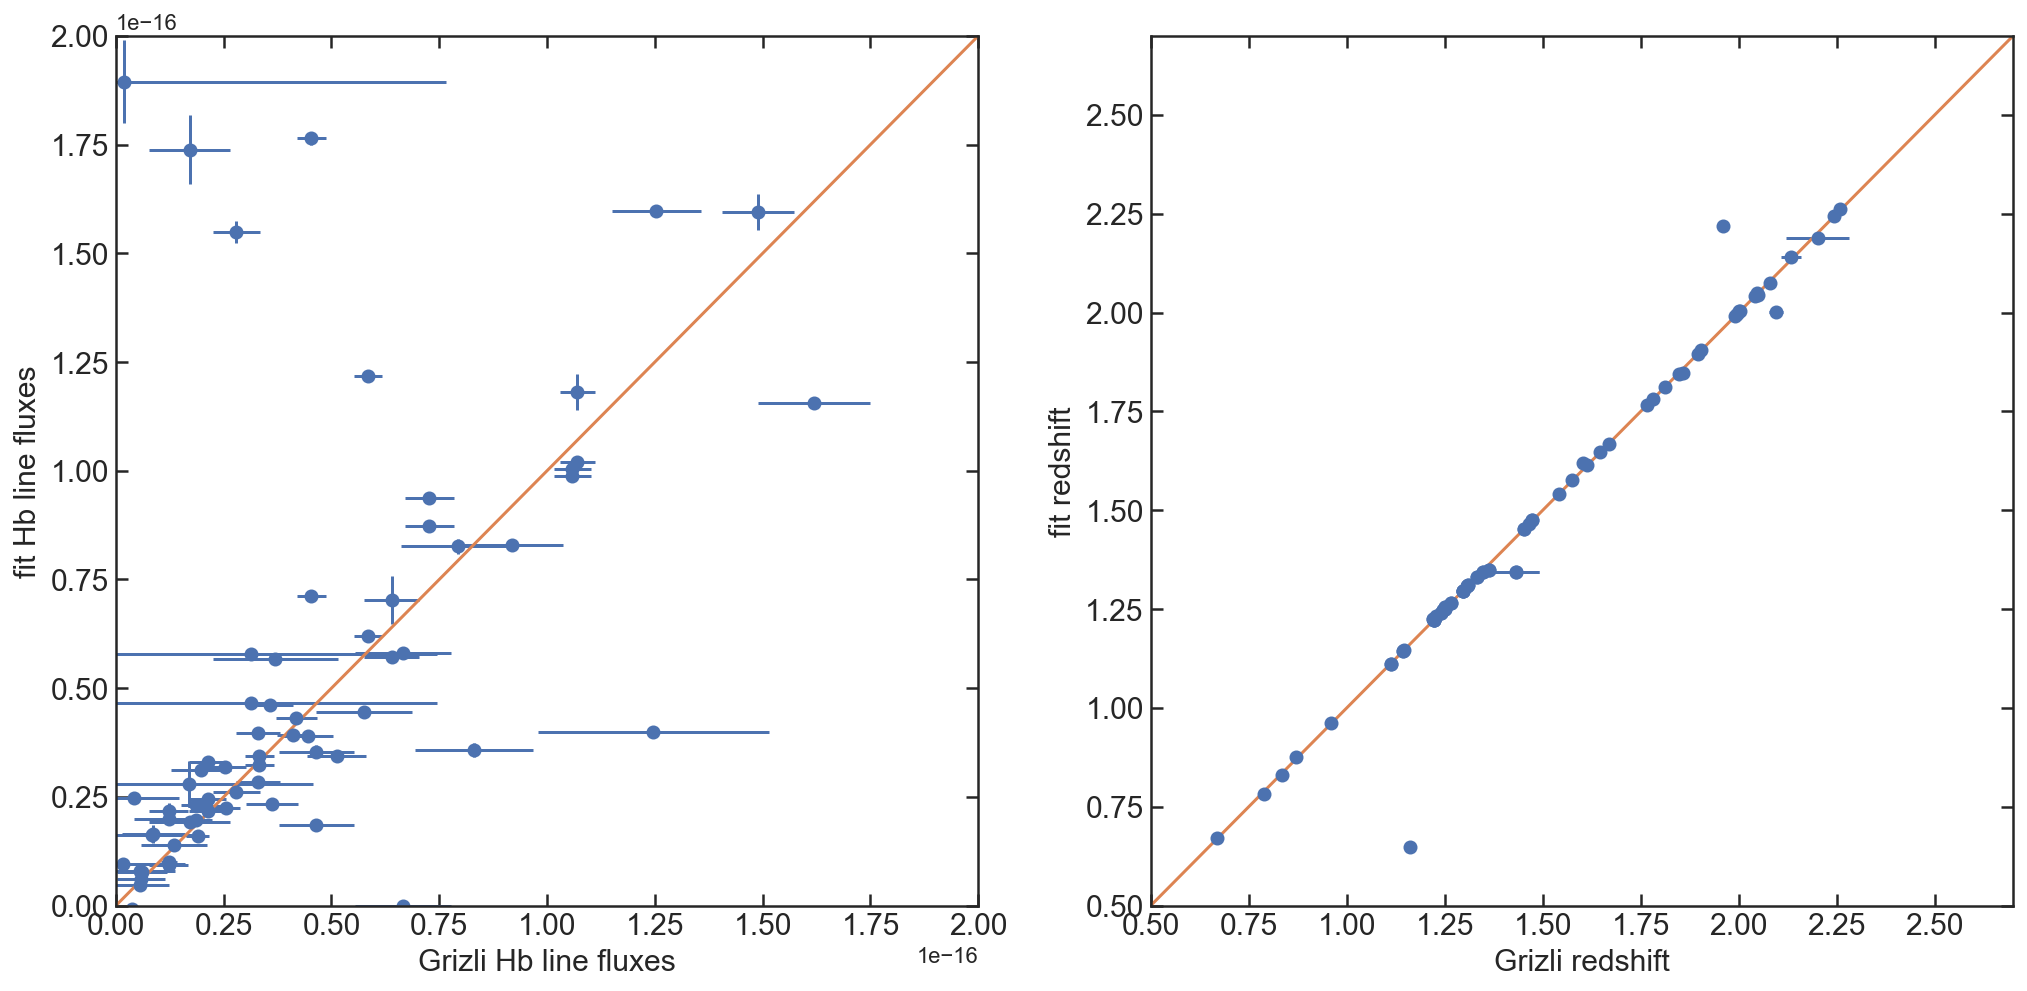

In [104]:
gs = gridspec.GridSpec(1,2)

plt.figure(figsize=[17,8])
plt.subplot(gs[0])
plt.errorbar(Hb_g_fluxes, Hb_v_fluxes,xerr = Hb_g_err, yerr=Hb_v_err ,linestyle = 'none', marker = 'o')
plt.plot([0,1.1E-15],[0,1.1E-15])
plt.xlim(0,2E-16)
plt.ylim(0,2E-16)


plt.ylabel('fit Hb line fluxes', fontsize=15)
plt.xlabel('Grizli Hb line fluxes', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(gs[1])
plt.errorbar(z50_g, z_v, xerr = zer_g, yerr=zerr_v ,linestyle = 'none', marker = 'o')
plt.plot([0,4],[0,4])
plt.xlim(0.5,2.7)
plt.ylim(0.5,2.7)

plt.ylabel('fit redshift', fontsize=15)
plt.xlabel('Grizli redshift', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('../plots/Hb_compare.png', bbox_inches = 'tight')

# Plot OIII

In [105]:
fls = glob('../data/linefits/*OIII_*')

field = [os.path.basename(U).split('_')[0] for U in fls]
gid = [os.path.basename(U).split('_')[1] for U in fls]

zfl = []
for i in range(len(field)):
    zfl.append(glob('../data/posteriors/{}_{}*Mfit_Pz.npy'.format(field[i], gid[i]))[0])

In [106]:
OIII_g_fluxes = []
OIII_g_err = []
z50_g = []
zer_g = []
for i in range(len(field)):
    if field[i][1] == 'N':
        for F in GND_lines:
            FLUX = F.query('ID == {}'.format(gid[i])).OIII_FLUX.values * 1E-17
            ERR = F.query('ID == {}'.format(gid[i])).OIII_FLUX_ERR.values * 1E-17
            RS = F.query('ID == {}'.format(gid[i])).z_50.values

            RSERRH = F.query('ID == {}'.format(gid[i])).z_84.values
            RSERRL = F.query('ID == {}'.format(gid[i])).z_16.values
            if len(FLUX) > 0:
                OIII_g_fluxes.append(FLUX[0])
                OIII_g_err.append(ERR[0])
                z50_g.append(RS[0])
                zer_g.append((RSERRH[0] - RSERRL[0]) / 2)
                break                

    if field[i][1] == 'S':
        for F in GSD_lines:
            FLUX = F.query('ID == {}'.format(gid[i])).OIII_FLUX.values * 1E-17
            ERR = F.query('ID == {}'.format(gid[i])).OIII_FLUX_ERR.values * 1E-17
            RS = F.query('ID == {}'.format(gid[i])).z_50.values

            RSERRH = F.query('ID == {}'.format(gid[i])).z_84.values
            RSERRL = F.query('ID == {}'.format(gid[i])).z_16.values
            if len(FLUX) > 0:
                OIII_g_fluxes.append(FLUX[0])
                OIII_g_err.append(ERR[0])
                z50_g.append(RS[0])
                zer_g.append((RSERRH[0] - RSERRL[0]) / 2)
                break                
OIII_v_fluxes = []
OIII_v_err = []               
for f in fls:
    x,px = np.load(f)
    m, hci, mod = Highest_density_region(px,x)
    OIII_v_fluxes.append(m)
    OIII_v_err.append((hci[1] - hci[0]) / 2)  
    
z_v= []
zerr_v = []               
for f in zfl:
    x,px = np.load(f)
    m, hci, mod = Highest_density_region(px,x)
    z_v.append(m)
    zerr_v.append((hci[1] - hci[0]) / 2)  

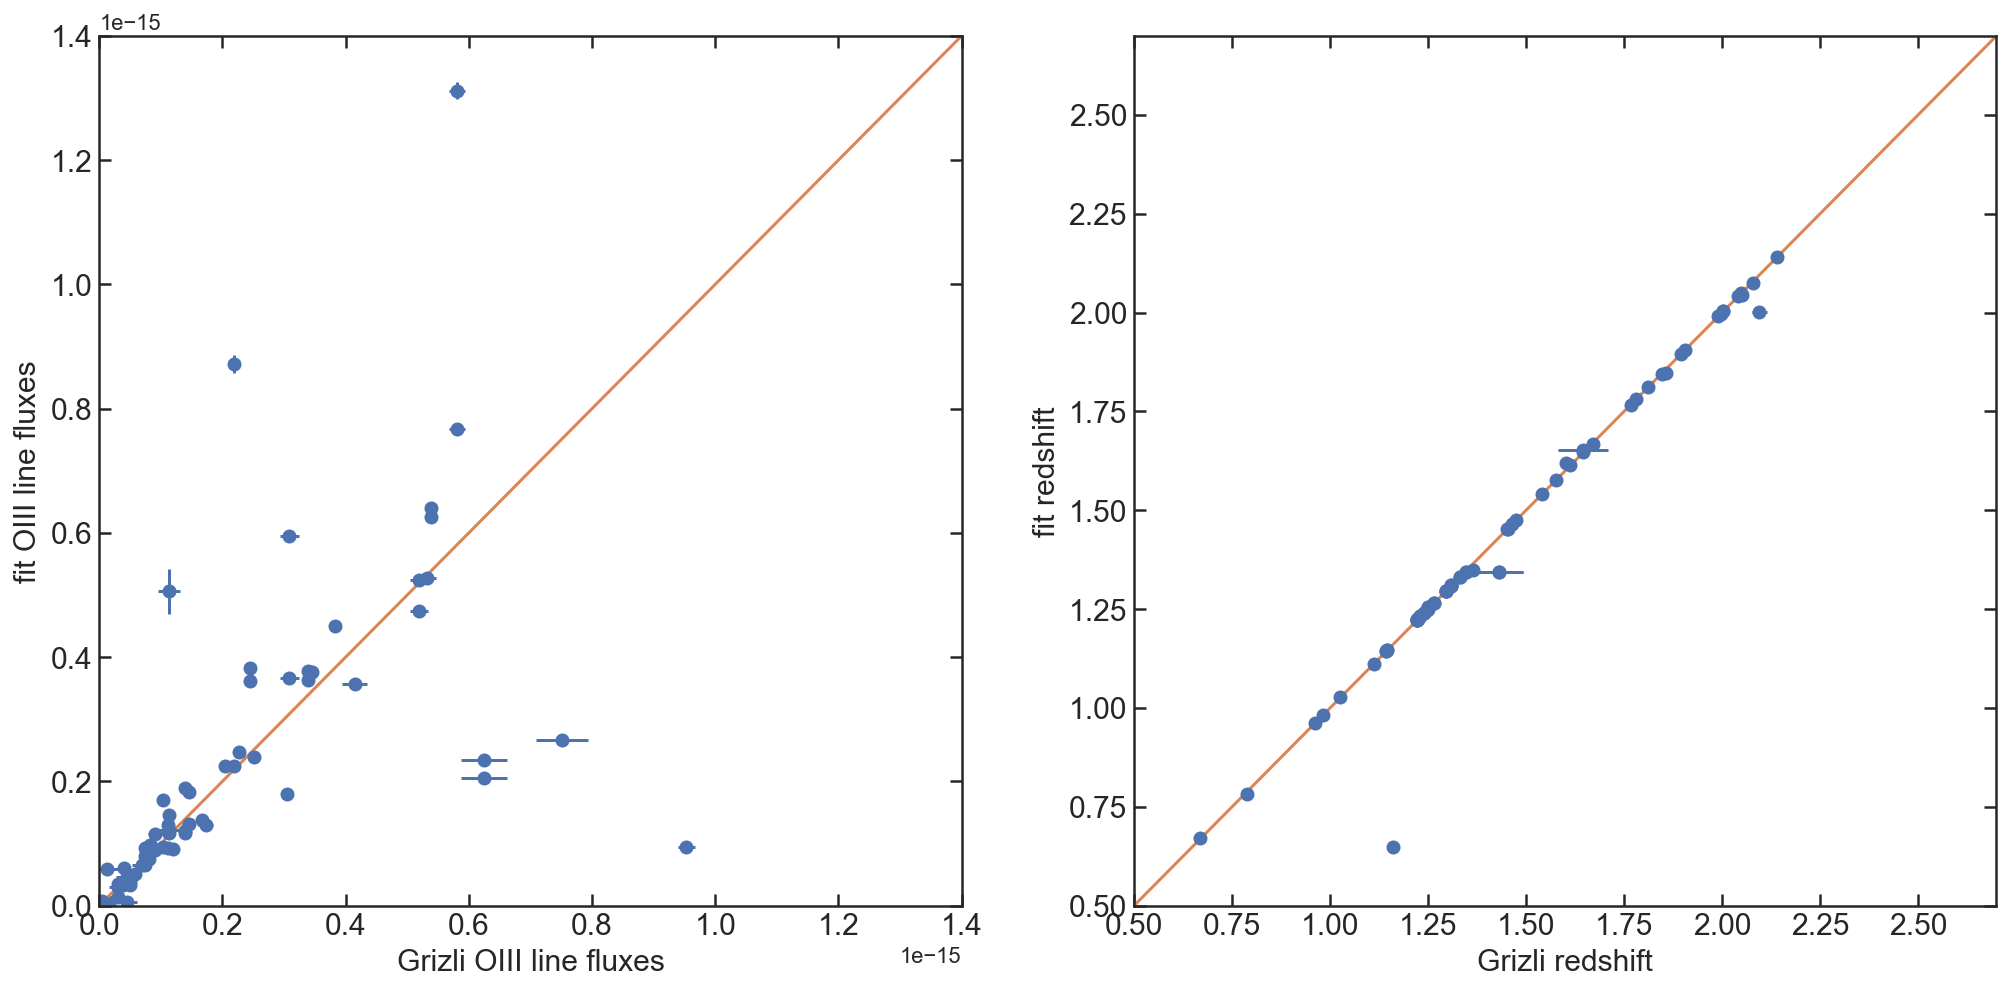

In [108]:
gs = gridspec.GridSpec(1,2)

plt.figure(figsize=[17,8])
plt.subplot(gs[0])
plt.errorbar(OIII_g_fluxes, OIII_v_fluxes,xerr = OIII_g_err, yerr=OIII_v_err ,linestyle = 'none', marker = 'o')
plt.plot([0,1.5E-15],[0,1.5E-15])
plt.xlim(0,1.4E-15)
plt.ylim(0,1.4E-15)


plt.ylabel('fit OIII line fluxes', fontsize=15)
plt.xlabel('Grizli OIII line fluxes', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(gs[1])
plt.errorbar(z50_g, z_v, xerr = zer_g, yerr=zerr_v ,linestyle = 'none', marker = 'o')
plt.plot([0,4],[0,4])
plt.xlim(0.5,2.7)
plt.ylim(0.5,2.7)

plt.ylabel('fit redshift', fontsize=15)
plt.xlabel('Grizli redshift', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('../plots/OIII_compare.png', bbox_inches = 'tight')

# Plot OII

In [109]:
fls = glob('../data/linefits/*OII_*')

field = [os.path.basename(U).split('_')[0] for U in fls]
gid = [os.path.basename(U).split('_')[1] for U in fls]

zfl = []
for i in range(len(field)):
    zfl.append(glob('../data/posteriors/{}_{}*Mfit_Pz.npy'.format(field[i], gid[i]))[0])

In [110]:
OII_g_fluxes = []
OII_g_err = []
z50_g = []
zer_g = []
for i in range(len(field)):
    if field[i][1] == 'N':
        for F in GND_lines:
            FLUX = F.query('ID == {}'.format(gid[i])).OII_FLUX.values * 1E-17
            ERR = F.query('ID == {}'.format(gid[i])).OII_FLUX_ERR.values * 1E-17
            RS = F.query('ID == {}'.format(gid[i])).z_50.values
   
            RSERRH = F.query('ID == {}'.format(gid[i])).z_84.values
            RSERRL = F.query('ID == {}'.format(gid[i])).z_16.values
            if len(FLUX) > 0:
                OII_g_fluxes.append(FLUX[0])
                OII_g_err.append(ERR[0])
                z50_g.append(RS[0])
                zer_g.append((RSERRH[0] - RSERRL[0]) / 2)
                break                

    if field[i][1] == 'S':
        for F in GSD_lines:
            FLUX = F.query('ID == {}'.format(gid[i])).OII_FLUX.values * 1E-17
            ERR = F.query('ID == {}'.format(gid[i])).OII_FLUX_ERR.values * 1E-17
            RS = F.query('ID == {}'.format(gid[i])).z_50.values

            RSERRH = F.query('ID == {}'.format(gid[i])).z_84.values
            RSERRL = F.query('ID == {}'.format(gid[i])).z_16.values
            if len(FLUX) > 0:
                OII_g_fluxes.append(FLUX[0])
                OII_g_err.append(ERR[0])
                z50_g.append(RS[0])
                zer_g.append((RSERRH[0] - RSERRL[0]) / 2)
                break                
OII_v_fluxes = []
OII_v_err = []               
for f in fls:
    x,px = np.load(f)
    m, hci, mod = Highest_density_region(px,x)
    OII_v_fluxes.append(m)
    OII_v_err.append((hci[1] - hci[0]) / 2)  
    
z_v= []
zerr_v = []               
for f in zfl:
    x,px = np.load(f)
    m, hci, mod = Highest_density_region(px,x)
    z_v.append(m)
    zerr_v.append((hci[1] - hci[0]) / 2)  

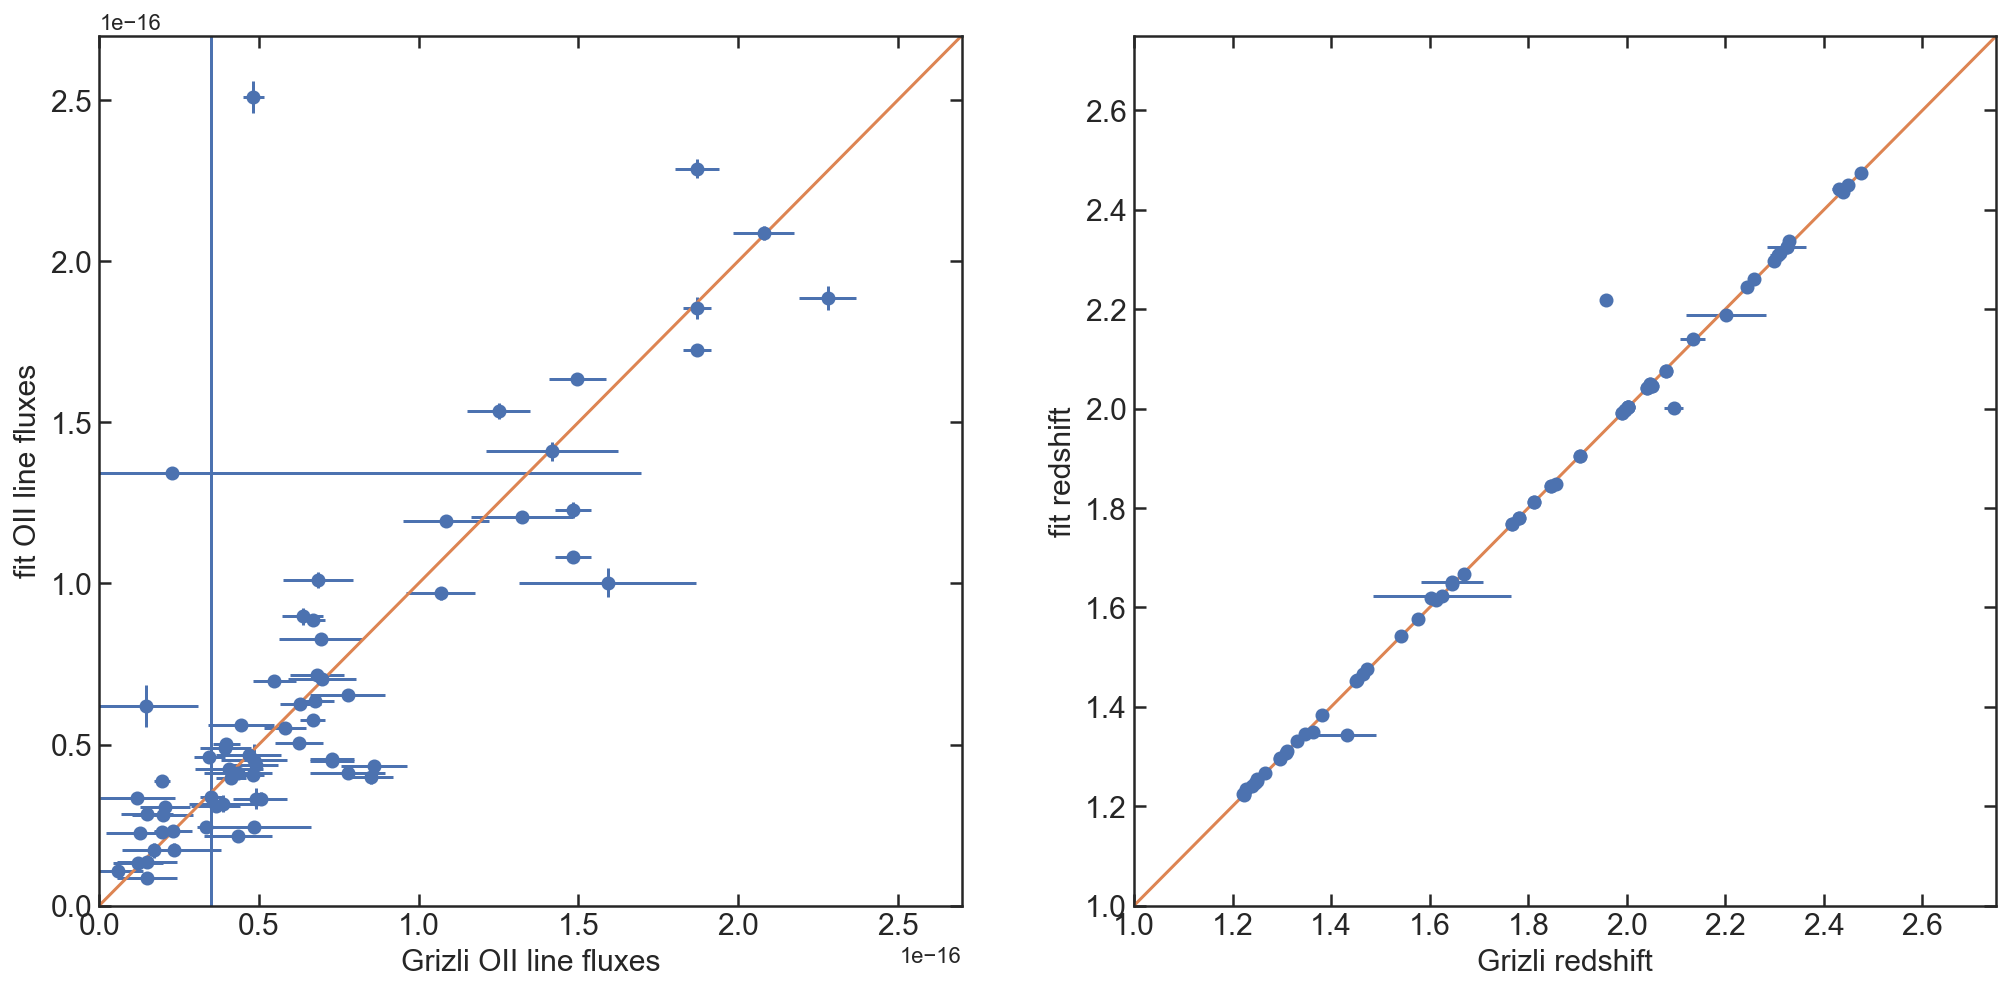

In [113]:
gs = gridspec.GridSpec(1,2)

plt.figure(figsize=[17,8])
plt.subplot(gs[0])
plt.errorbar(np.array(OII_g_fluxes), np.array(OII_v_fluxes),
             xerr = np.array(OII_g_err), yerr=np.array(OII_v_err),linestyle = 'none', marker = 'o')
plt.plot([0,1.5E-15],[0,1.5E-15])
plt.xlim(0,0.27E-15)
plt.ylim(0,0.27E-15)


plt.ylabel('fit OII line fluxes', fontsize=15)
plt.xlabel('Grizli OII line fluxes', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(gs[1])
plt.errorbar(z50_g, z_v, xerr = zer_g, yerr=zerr_v ,linestyle = 'none', marker = 'o')
plt.plot([0,4],[0,4])
plt.xlim(1,2.75)
plt.ylim(1,2.75)

plt.ylabel('fit redshift', fontsize=15)
plt.xlabel('Grizli redshift', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('../plots/OII_compare.png', bbox_inches = 'tight')

# stack line posteriors

In [131]:
fls = glob('../data/linefits/*Hb*')

field = [os.path.basename(U).split('_')[0] for U in fls]
gid = [os.path.basename(U).split('_')[1] for U in fls]

gal_set = []
for i in range(len(field)):
    if gid[i] in gal_set:
        print(field[i],gid[i])
    gal_set.append(gid[i])

GND 10639
GND 11279
GND 11839
GND 17927
GND 19235
GND 20635
GND 28379
GND 32671
GND 32719
GND 37893
GSD 20651
GSD 25641
GSD 37001
GSD 38616
GSD 40078
GSD 40108
GSD 40192
GSD 40270
GSD 40759
GSD 48652


(5.709748441871351e-17, [5.600588405355488e-17, 5.797504549658613e-17], array([0.]))
(7.025413416403832e-17, [6.509405971713154e-17, 7.6047901964074e-17], array([0.]))


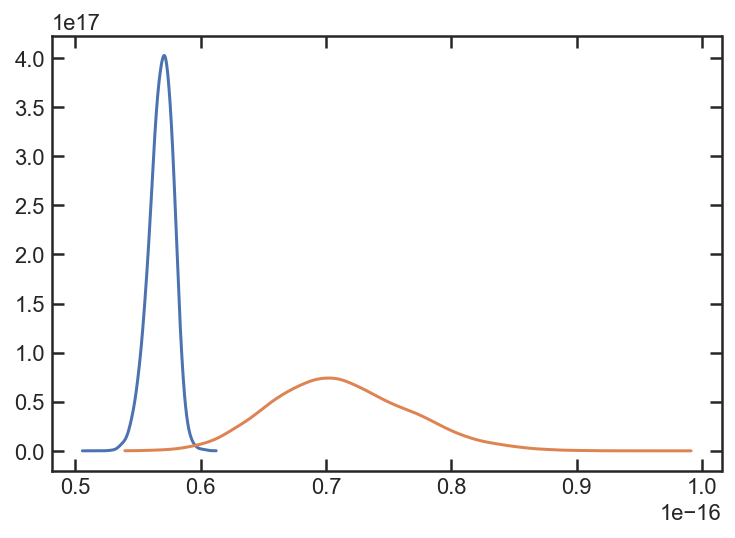

In [172]:
### function to build
### auto remove bad pdf
### id by redshift
### filter out too high and too low 
### if both good combine


def line_post_comb(fls, zfl, line):
    x,px = np.load(fls[0])
    y,py = np.load(fls[1])

    mx, hdrx, modx = Highest_density_region(px,x)
    my, hdry, mody = Highest_density_region(py,y)
    
    ###select mode
    lowlim = 1E-20
    hilim = 1E-14
    
    MODE = 'none'
    
    if (not lowlim < mx < hilim) | (not lowlim < my < hilim):
        MODE = 'filter'
    
    if MODE == 'none' and np.log10(np.abs(mx - my)/mx) > 1:
        MODE = 'autoselect'
        
    if MODE == 'none':
        MODE = 'combine'

    ###filter
    if MODE == 'filter':
        if lowlim < mx < hilim:
            return x,px
        
        if lowlim < my < hilim:
            return y,py
        
    ###autoselect by z
    if MODE == 'autoselect':
        z,pz = np.load(zfl)
        mz, hdrz, modz = Highest_density_region(pz,z)

        ln_nm = []
        ln_wv = []
        for k in args['t1']:
            if k[0] == 'l':
                ln_wv.append(np.round(args['t1'][k].wave[args['t1'][k].flux == max(args['t1'][k].flux)][0]))
                ln_nm.append(k[5:])
                
        Bllim = 7700
        Bhlim = 11300
        
        Rllim = 11300
        Rhlim = 16500
        
        LW = ln_wv[ln_nm == line]
        
        OLW = LW * (1+mz)
        
        if Bllim <= OLW <= Bhlim:
            return x,px

        if Rllim <= OLW <= Rhlim:
            return y,py 
            
            
    ###combine
    if MODE == 'combine':
        pass


x,px = np.load('../data/linefits/GSD_48652_SFMfit_Pline Hb_0.npy')
y,py = np.load('../data/linefits/GSD_48652_SFMfit_Pline Hb_1.npy')

print(Highest_density_region(px,x))
print(Highest_density_region(py,y))


plt.plot(x,px)
plt.plot(y,py)

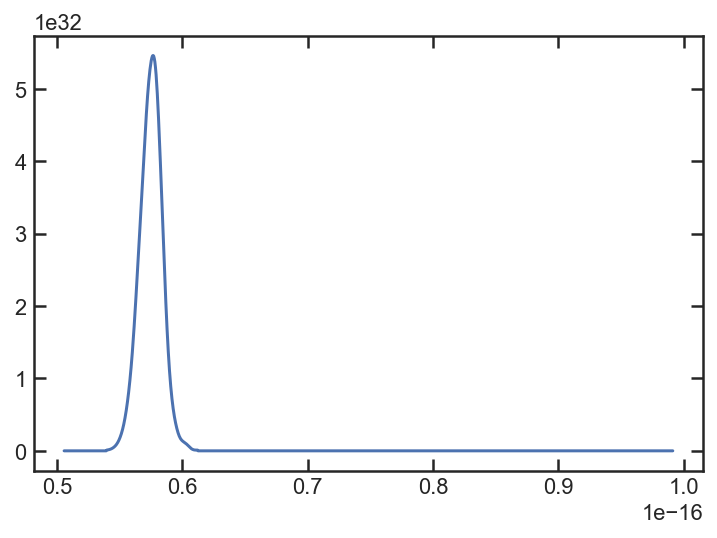

In [179]:
allmin = [min(x),min(y)]
allmax = [max(x),max(y)]

X = np.linspace(min(allmin), max(allmax),1000)
ipx = interp1d(x,px,bounds_error=False, fill_value=True)(X)
ipy = interp1d(y,py,bounds_error=False, fill_value=True)(X)


plt.plot(X, ipx * ipy)

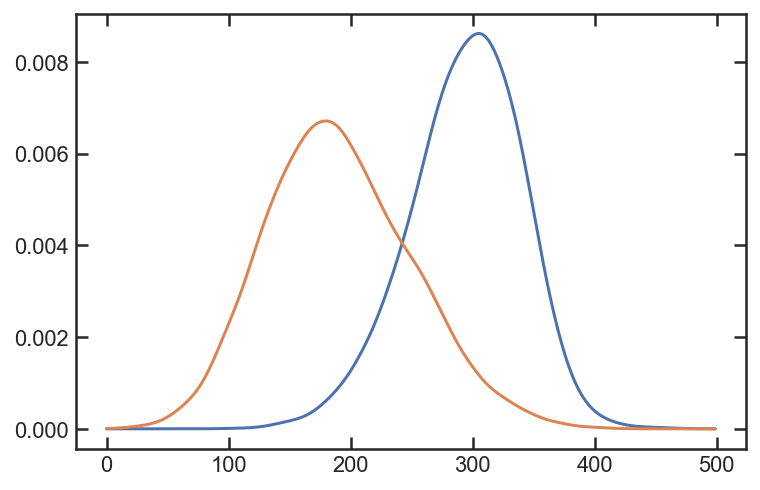

In [182]:
plt.plot(np.arange(500), px/np.trapz(px,np.arange(500)))
plt.plot(np.arange(500), py/np.trapz(py,np.arange(500)))

In [150]:
(not 1E-20 < 5.230565527677531e-30 < 1E-14) | (not 1E-20 < 5.805858287347268e-17 < 1E-14)

True

In [169]:
ln_nm = []
ln_wv = []
for k in args['t1']:
    if k[0] == 'l':
        ln_wv.append(np.round(args['t1'][k].wave[args['t1'][k].flux == max(args['t1'][k].flux)][0]))
        ln_nm.append(k[5:])
        

In [170]:
ln_nm

['PaB',
 'HeI-1083',
 'SIII',
 'OII-7325',
 'ArIII-7138',
 'SII',
 'Ha',
 'OI-6302',
 'HeI-5877',
 'OIII',
 'Hb',
 'OIII-4363',
 'Hg',
 'Hd',
 'H7',
 'H8',
 'H9',
 'H10',
 'NeIII-3867',
 'OII',
 'NeVI-3426',
 'NeV-3346',
 'MgII',
 'CIV-1549',
 'CIII-1908',
 'OIII-1663',
 'HeII-1640',
 'NIII-1750',
 'NIV-1487',
 'NV-1240',
 'Lya']